In [1]:
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import os
import torch
import matplotlib.pyplot as plt


In [2]:
# set seeds
torch.cuda.empty_cache()
torch.manual_seed(2222)
torch.cuda.manual_seed_all(2222)

In [3]:
# Augmentation transform
aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
# load data
train_data = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
test_data = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=aug_test)
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46988631.93it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1,drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(p=drop_rate)  # Add dropout layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.view_reshape = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.view_reshape = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout
        out = self.bn2(self.conv2(out))
        out += self.view_reshape(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10,drop_rate=0.3):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.drop_rate = drop_rate
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.linear = nn.Linear(1024, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
def decay_learning_rate(optimizer, epoch, base_lr=0.1, min_lr=0.001):
    """ Apply advanced dynamic adjustments to the learning rate. """
    if epoch < 5:
        lr = base_lr * (epoch / 5)  # Linear warm-up over 5 epochs
    elif epoch < 15:
        lr = base_lr
    else:
        lr = min_lr + (base_lr - min_lr) * (0.5 ** (epoch - 15))  # Exponential decay after 15 epochs
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
# Network structure
model = ResNet(BasicBlock, [3,3,2]).cuda()
summary(model, input_size=(3,32,32))

# HyperParametes Setting
# epoch number
epoch_num = 30
# learning rate changes with epoch changes
max_rate = 0.1
record = 'model.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []
# loss function
Loss = torch.nn.CrossEntropyLoss()
# SGD add momentum better performance
optimizer = torch.optim.SGD(model.parameters(),lr=max_rate,momentum=0.8,nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
          Dropout-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1, 64,

In [9]:
def train_epoch(model, dataloader, optimizer, loss_func, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        decay_learning_rate(optimizer,epoch,max_rate)
        optimizer.step()
        total_loss += loss.item()
        preds = torch.max(outputs, 1)[1]
        accuracy = (preds == labels).float().mean()
        total_accuracy += accuracy.item()
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader) * 100
    return avg_loss, avg_accuracy


def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            total_loss += loss.item()
            preds = torch.max(outputs, 1)[1]
            accuracy = (preds == labels).float().mean()
            total_accuracy += accuracy.item()
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader) * 100
    return avg_loss, avg_accuracy

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        return checkpoint
    else:
        return None

In [10]:
# Training setup
model.to(device)
loss_func = Loss
optimizer = optimizer
record = 'path_to_checkpoint.pth.tar'
checkpoint = load_checkpoint(record)

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
else:
    train_loss_history, test_loss_history = [], []
    train_accuracy_history, test_accuracy_history = [], []
    for epoch in range(1, epoch_num + 1):
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_func, device)
        test_loss, test_accuracy = evaluate(model, test_dataloader, loss_func, device)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch #{epoch:2}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Loss': loss_func,
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'test_accuracy_history': test_accuracy_history,
            'train_accuracy_history': train_accuracy_history
        }, record)



Epoch # 1, Train Accuracy: 49.76%, Test Accuracy: 57.11%
Epoch # 2, Train Accuracy: 66.40%, Test Accuracy: 72.36%
Epoch # 3, Train Accuracy: 73.85%, Test Accuracy: 77.59%
Epoch # 4, Train Accuracy: 77.76%, Test Accuracy: 79.55%
Epoch # 5, Train Accuracy: 80.74%, Test Accuracy: 79.81%
Epoch # 6, Train Accuracy: 83.79%, Test Accuracy: 82.86%
Epoch # 7, Train Accuracy: 85.70%, Test Accuracy: 83.12%
Epoch # 8, Train Accuracy: 87.22%, Test Accuracy: 86.81%
Epoch # 9, Train Accuracy: 88.33%, Test Accuracy: 86.96%
Epoch #10, Train Accuracy: 89.50%, Test Accuracy: 86.21%
Epoch #11, Train Accuracy: 90.19%, Test Accuracy: 87.74%
Epoch #12, Train Accuracy: 90.94%, Test Accuracy: 87.48%
Epoch #13, Train Accuracy: 91.69%, Test Accuracy: 86.34%
Epoch #14, Train Accuracy: 92.34%, Test Accuracy: 88.74%
Epoch #15, Train Accuracy: 92.79%, Test Accuracy: 89.36%
Epoch #16, Train Accuracy: 94.98%, Test Accuracy: 91.72%
Epoch #17, Train Accuracy: 96.37%, Test Accuracy: 92.06%
Epoch #18, Train Accuracy: 97.0

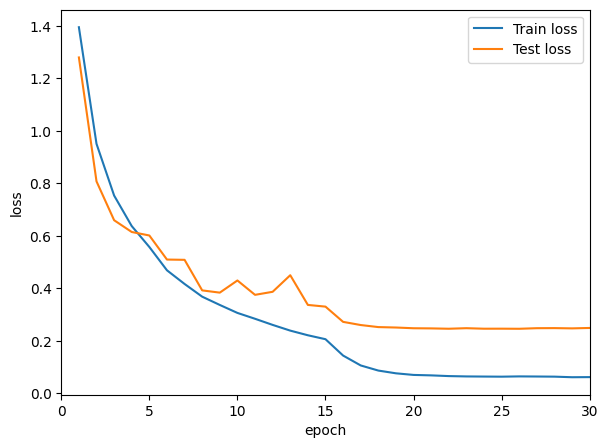

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,epoch_num+1),train_loss_history,label='Train loss')
plt.plot(range(1,epoch_num+1),test_loss_history,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([0, epoch_num])
plt.legend()

[49.764226342711, 66.40065537999048, 73.84550832116695, 77.75655370539106, 80.74168797649081, 83.7855658567775, 85.70292518876703, 87.22426470588235, 88.32880435392376, 89.49968031300303, 90.19181586592399, 90.93630115699281, 91.68718030385654, 92.33975384546362, 92.79092071611254, 94.97562340458336, 96.36548913043478, 97.0504315917754, 97.44045716112531, 97.62707800816392, 97.84566816466544, 97.85406010230179, 97.83248082756081, 97.85406010230179, 97.965952685422, 97.88443095543805, 97.87324168493072, 97.90161445622554, 97.96635231093677, 97.95196611253198]


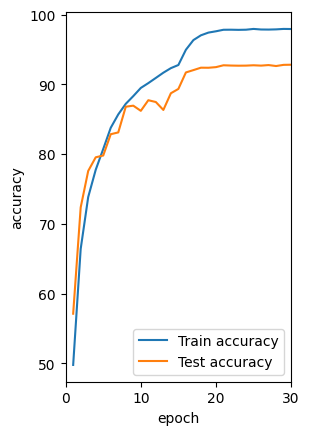

In [12]:
plt.subplot(1,2,2)
print(train_accuracy_history)
plt.plot(range(1,epoch_num+1),train_accuracy_history,label='Train accuracy')
plt.plot(range(1,epoch_num+1),test_accuracy_history,label='Test accuracy')
plt.xlim([0, epoch_num])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()